1.1 Extracting a Subset of the Dataset

In [ ]:
# Section 1.1: Extracting a Subset of the Dataset (Corrected Implementation)
import json
import pandas as pd
from collections import defaultdict

def extract_yelp_subset_optimized():
   
    # File paths
    business_file = 'yelp_academic_dataset_business.json'
    review_file   = 'yelp_academic_dataset_review.json'
    user_file     = 'yelp_academic_dataset_user.json'
    
    # Step 1: Identify restaurant businesses
    restaurant_ids  = set()
    restaurant_info = {}
    with open(business_file, 'r', encoding='utf-8') as f:
        for line in f:
            b = json.loads(line)
            if b.get('categories') and 'Restaurant' in b['categories']:
                restaurant_ids.add(b['business_id'])
                restaurant_info[b['business_id']] = {
                    'name': b['name'],
                    'categories': b['categories'],
                    'city': b.get('city',''),
                    'state': b.get('state','')
                }
    
    # Step 2: Count reviews per user and per restaurant
    user_restaurant_count    = defaultdict(int)
    restaurant_review_count  = defaultdict(int)
    with open(review_file, 'r', encoding='utf-8') as f:
        for line in f:
            r = json.loads(line)
            if r['business_id'] in restaurant_ids:
                user_restaurant_count[r['user_id']]       += 1
                restaurant_review_count[r['business_id']] += 1
    
    # Step 3: Select qualified users (>=30 reviews)
    qualified_users = {u for u,c in user_restaurant_count.items()    if c>=30}
    # Step 4: Select qualified restaurants (>=300 reviews)
    qualified_restaurants = {b for b,c in restaurant_review_count.items() if c>=300}
    
    # Step 5: Extract final reviews
    final_reviews = []
    with open(review_file, 'r', encoding='utf-8') as f:
        for line in f:
            r = json.loads(line)
            if r['user_id'] in qualified_users and r['business_id'] in qualified_restaurants:
                final_reviews.append(r)
    
    # Step 6: Build final DataFrames
    # Users
    final_users = []
    with open(user_file, 'r', encoding='utf-8') as f:
        for line in f:
            u = json.loads(line)
            if u['user_id'] in qualified_users:
                final_users.append({
                    'user_id':       u['user_id'],
                    'name':          u.get('name',''),
                    'review_count':  u.get('review_count',0),
                    'average_stars': u.get('average_stars',0)
                })
    users_df       = pd.DataFrame(final_users)
    # Restaurants
    final_rests    = []
    for bid in qualified_restaurants:
        info = restaurant_info.get(bid)
        if info:
            d = info.copy()
            d['business_id'] = bid
            final_rests.append(d)
    restaurants_df = pd.DataFrame(final_rests)
    # Reviews
    reviews_df     = pd.DataFrame(final_reviews)
    
    # Save to CSV
    users_df.to_csv('users_subset.csv', index=False)
    restaurants_df.to_csv('restaurants_subset.csv', index=False)
    reviews_df.to_csv('reviews_subset.csv', index=False)
    
    return users_df, restaurants_df, reviews_df

# Execute extraction
users_df, restaurants_df, reviews_df = extract_yelp_subset_optimized()

def generate_report_table(users_df, restaurants_df, reviews_df):
    """Generate the required Table 1 report."""
    print("\n" + "="*50)
    print("DATASET SUBSET EXTRACTION REPORT")
    print("="*50)
    print("\nTable 1: Number of records in extracted dataset subset")
    print("-" * 45)
    print(f"{'Category':<15} {'Records Count':<15}")
    print("-" * 45)
    print(f"{'Users':<15} {len(users_df):<15}")
    print(f"{'Restaurants':<15} {len(restaurants_df):<15}")
    print(f"{'Reviews':<15} {len(reviews_df):<15}")
    print("-" * 45)
    return {
        'users':       len(users_df),
        'restaurants': len(restaurants_df),
        'reviews':     len(reviews_df)
    }

# Generate report
report_stats = generate_report_table(users_df, restaurants_df, reviews_df)



DATASET SUBSET EXTRACTION REPORT

Table 1: Number of records in extracted dataset subset
---------------------------------------------
Category        Records Count  
---------------------------------------------
Users           17143          
Restaurants     3248           
Reviews         422898         
---------------------------------------------


1.2 Holdout

In [ ]:
import pandas as pd
from datetime import datetime

def create_holdout_split(reviews_df):

    print("Section 1.2: Data Holdout Split")
    print("=" * 50)
    
    # Step 1: Convert date column to datetime format
    reviews_df['date'] = pd.to_datetime(reviews_df['date'])
    print("1. Converting date field to datetime format...")
    print(f"   Date range: {reviews_df['date'].min()} to {reviews_df['date'].max()}")
    
    # Step 2: Sort by date (oldest first)
    print("2. Sorting by date (oldest first)...")
    reviews_sorted = reviews_df.sort_values('date').reset_index(drop=True)
    total_reviews = len(reviews_sorted)
    print(f"   Total reviews: {total_reviews}")
    
    # Step 3: Extract training set (oldest 20,000 records)
    print("3. Extracting training set (oldest 20,000 records)...")
    train_size = 20000
    if total_reviews < train_size:
        raise ValueError(f"Total reviews ({total_reviews}) is less than 20,000!")
    train_data = reviews_sorted.iloc[:train_size].copy()
    remaining_data = reviews_sorted.iloc[train_size:].copy()
    print(f"   Training set: {len(train_data)} reviews ({train_data['date'].min()} to {train_data['date'].max()})")
    
    # Step 4: Split remaining data equally into validation and test
    print("4. Splitting remaining data into validation and test...")
    remaining_size = len(remaining_data)
    val_size = remaining_size // 2
    val_data  = remaining_data.iloc[:val_size].copy()
    test_data = remaining_data.iloc[val_size:].copy()
    print(f"   Validation set: {len(val_data)} reviews ({val_data['date'].min()} to {val_data['date'].max()})")
    print(f"   Test set:       {len(test_data)} reviews ({test_data['date'].min()} to {test_data['date'].max()})")
    
    # Step 5: Verify chronological order and equal split
    assert train_data['date'].max() <= val_data['date'].min(), "Train/Val order incorrect"
    assert val_data['date'].max() <= test_data['date'].min(),  "Val/Test order incorrect"
    size_diff = abs(len(val_data) - len(test_data))
    assert size_diff <= 1, f"Val/Test size difference exceeds 1 ({size_diff})"
    print("5. Split verified (chronological order & equal sizes).")
    
    # Step 6: Save the splits
    print("6. Saving data splits to CSV...")
    train_data.to_csv('train_reviews.csv', index=False)
    val_data.to_csv('val_reviews.csv',   index=False)
    test_data.to_csv('test_reviews.csv',  index=False)
    print("   ✓ CSV files saved successfully")
    
    # Step 7: Generate summary report
    print("\n" + "=" * 60)
    print("Final Data Split Report")
    print("=" * 60)
    summary = {
        'Dataset':      ['Train', 'Validation', 'Test', 'Total'],
        'Records':      [len(train_data), len(val_data), len(test_data), total_reviews],
        'Start Date':   [
            train_data['date'].min().strftime('%Y-%m-%d'),
            val_data['date'].min().strftime('%Y-%m-%d'),
            test_data['date'].min().strftime('%Y-%m-%d'),
            reviews_sorted['date'].min().strftime('%Y-%m-%d')
        ],
        'End Date':     [
            train_data['date'].max().strftime('%Y-%m-%d'),
            val_data['date'].max().strftime('%Y-%m-%d'),
            test_data['date'].max().strftime('%Y-%m-%d'),
            reviews_sorted['date'].max().strftime('%Y-%m-%d')
        ],
        'Percentage': [
            f"{len(train_data)/total_reviews*100:.1f}%",
            f"{len(val_data)/total_reviews*100:.1f}%",
            f"{len(test_data)/total_reviews*100:.1f}%",
            "100.0%"
        ]
    }
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))
    
    return train_data, val_data, test_data

# Execute the corrected holdout split
# (reviews_df assumed to be the DataFrame from Section 1.1)
train_data, val_data, test_data = create_holdout_split(reviews_df)


Section 1.2: Data Holdout Split
1. Converting date field to datetime format...
   Date range: 2005-03-04 02:06:36 to 2022-01-19 19:42:22
2. Sorting by date (oldest first)...
   Total reviews: 422898
3. Extracting training set (oldest 20,000 records)...
   Training set: 20000 reviews (2005-03-04 02:06:36 to 2010-05-28 19:30:18)
4. Splitting remaining data into validation and test...
   Validation set: 201449 reviews (2010-05-28 19:30:25 to 2016-08-11 17:51:12)
   Test set:       201449 reviews (2016-08-11 18:08:38 to 2022-01-19 19:42:22)
5. Split verified (chronological order & equal sizes).
6. Saving data splits to CSV...
   ✓ CSV files saved successfully

Final Data Split Report
   Dataset  Records Start Date   End Date Percentage
     Train    20000 2005-03-04 2010-05-28       4.7%
Validation   201449 2010-05-28 2016-08-11      47.6%
      Test   201449 2016-08-11 2022-01-19      47.6%
     Total   422898 2005-03-04 2022-01-19     100.0%


2.1 Training Word2vec and FastText

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, FastText
import pandas as pd

try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

def preprocess_text(text):

    #Step 1:Tokenize using NLTK and Convert to lowercase
    return [token.lower() for token in word_tokenize(text)]

def train_embeddings_with_defaults(train_data):
    
    # Preprocess all training texts
    train_texts = [preprocess_text(text) for text in train_data['text'] if pd.notna(text)]

    # Train Word2Vec model with DEFAULT parameters
    word2vec_model = Word2Vec(
        sentences=train_texts,
        seed=1234
    )

    # Train FastText model with DEFAULT parameters
    fasttext_model = FastText(
        sentences=train_texts,
        seed=1234
    )

    return word2vec_model, fasttext_model

def find_similar_words(word2vec_model, fasttext_model, target_words=['tasty', 'give']):
    
    results = {}
    for word in target_words:
        results[word] = {}
        # Word2Vec similarities
        try:
            w2v_similar = word2vec_model.wv.most_similar(word, topn=15)
            results[word]['word2vec'] = [item[0] for item in w2v_similar]
        except KeyError:
            results[word]['word2vec'] = ['N/A - OOV'] * 15

        # FastText similarities
        try:
            ft_similar = fasttext_model.wv.most_similar(word, topn=15)
            results[word]['fasttext'] = [item[0] for item in ft_similar]
        except KeyError:
            results[word]['fasttext'] = ['N/A - OOV'] * 15

    return results

def create_similarity_table_exact_format(similar_words):
    
    print("\nTable 2: Template for reporting similar words")
    print("-" * 65)
    print(f"{'#':<3} | {'Tasty':<28} | {'Give':<28}")
    print(f"{'':>3} | {'FastText':<13} {'Word2Vec':<13} | {'FastText':<13} {'Word2Vec':<13}")
    print("-" * 65)

    tasty_w2v = similar_words['tasty']['word2vec']
    tasty_ft = similar_words['tasty']['fasttext']
    give_w2v = similar_words['give']['word2vec']
    give_ft = similar_words['give']['fasttext']

    for i in range(15):
        print(f"{i+1:<3} | {tasty_ft[i]:<13} {tasty_w2v[i]:<13} | {give_ft[i]:<13} {give_w2v[i]:<13}")


#Main Execution Block 

# 1. Preprocessing and 2. Learn Embeddings
word2vec_model, fasttext_model = train_embeddings_with_defaults(train_data)

# 3. Find Similar Words and create the report table
similar_words_results = find_similar_words(word2vec_model, fasttext_model)
create_similarity_table_exact_format(similar_words_results)


print("\n--- OOV Token Handling Difference ---")
oov_word = "givez"
try:
    word2vec_model.wv[oov_word]
    print(f"Word2Vec was able to generate a vector for '{oov_word}'.")
except KeyError:
    print(f"Word2Vec could not generate a vector for '{oov_word}' (KeyError).")

try:
    ft_vector = fasttext_model.wv[oov_word]
    print(f"FastText successfully generated a vector for '{oov_word}' with shape {ft_vector.shape}.")
except Exception as e:
    print(f"FastText failed to generate a vector for '{oov_word}': {e}")


Table 2: Template for reporting similar words
-----------------------------------------------------------------
#   | Tasty                        | Give                        
    | FastText      Word2Vec      | FastText      Word2Vec     
-----------------------------------------------------------------
1   | dynasty       yummy         | forgive       add          
2   | nasty         delicious     | given         call         
3   | deeeelicious  satisfying    | gives         giving       
4   | delicious     delish        | gi            consider     
5   | flavorful     good          | agave         deserve      
6   | delicious-    flavorful     | giwa          make         
7   | good-         refreshing    | gave          earn         
8   | tasteful      filling       | ive           rate         
9   | good          plentiful     | ave           warn         
10  | suspicious    strong        | add           kill         
11  | delish        scrumptious   | save          l

3 The Recommender System

d:\Pythonlatest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


################################################################################
###   PART 3.1: EXPERIMENTING TO SELECT BEST REGRESSOR TYPE   ###

Experimenting with 4 regression algorithms...
  - Ridge: Validation R² = 0.3556
  - Lasso: Validation R² = -0.0117
  - RandomForest: Validation R² = 0.3617
  - GradientBoosting: Validation R² = 0.3883

Experimenting with 4 regression algorithms...
  - Ridge: Validation R² = 0.3114
  - Lasso: Validation R² = -0.0117
  - RandomForest: Validation R² = 0.3026
  - GradientBoosting: Validation R² = 0.3371

Experimenting with 4 regression algorithms...
  - Ridge: Validation R² = 0.3591
  - Lasso: Validation R² = -0.0117
  - RandomForest: Validation R² = 0.3549
  - GradientBoosting: Validation R² = 0.3892

Experimenting with 4 regression algorithms...
  - Ridge: Validation R² = 0.2828
  - Lasso: Validation R² = -0.0117
  - RandomForest: Validation R² = 0.2371
  - GradientBoosting: Validation R² = 0.2631

Experimenting with 4 regression algorithms..

[I 2025-06-28 11:49:27,053] Using an existing study with name 'word2vec-SGNS_Ridge' instead of creating a new one.
Best trial: 15. Best value: 0.396715:   6%|▋         | 1/16 [51:40<12:55:02, 3100.19s/it]

[I 2025-06-28 12:41:06,952] Trial 22 finished with value: 0.37881614727518176 and parameters: {'vector_size': 150, 'window': 6, 'min_count': 8, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.04796524148291726}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  12%|█▎        | 2/16 [52:45<5:06:53, 1315.26s/it] 

[I 2025-06-28 12:42:12,331] Trial 21 finished with value: 0.3788239647650289 and parameters: {'vector_size': 150, 'window': 6, 'min_count': 8, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.07150029602982691}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  19%|█▉        | 3/16 [54:09<2:43:03, 752.59s/it] 

[I 2025-06-28 12:43:36,067] Trial 23 finished with value: 0.37881756261997135 and parameters: {'vector_size': 150, 'window': 6, 'min_count': 8, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.05231688972444513}. Best is trial 15 with value: 0.3967150298483938.
[I 2025-06-28 12:43:36,083] Trial 20 finished with value: 0.37881616061754586 and parameters: {'vector_size': 150, 'window': 6, 'min_count': 8, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.0480745419449932}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  31%|███▏      | 5/16 [1:43:44<3:34:15, 1168.71s/it]

[I 2025-06-28 13:33:10,464] Trial 24 finished with value: 0.3955003255322561 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 9, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.03121626297228914}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  38%|███▊      | 6/16 [1:46:17<2:26:04, 876.42s/it] 

[I 2025-06-28 13:35:44,385] Trial 26 finished with value: 0.3954958142975852 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 9, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.02091996191240135}. Best is trial 15 with value: 0.3967150298483938.
[I 2025-06-28 13:35:44,458] Trial 25 finished with value: 0.3954973689803737 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 9, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.02461075322115706}. Best is trial 15 with value: 0.3967150298483938.
[I 2025-06-28 13:35:44,615] Trial 27 finished with value: 0.39549621329086926 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 9, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.02183249484156032}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  56%|█████▋    | 9/16 [2:10:03<1:10:36, 605.19s/it]

[I 2025-06-28 13:59:30,843] Trial 28 finished with value: 0.3955493407112759 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 9, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.021296396187257552}. Best is trial 15 with value: 0.3967150298483938.


[I 2025-06-28 14:46:44,205] Trial 30 finished with value: 0.36394072878348716 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 10, 'epochs': 30, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.14398626627336378}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  62%|██████▎   | 10/16 [2:57:18<1:58:18, 1183.15s/it]

[I 2025-06-28 14:46:44,829] Trial 31 finished with value: 0.3639407170790724 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 10, 'epochs': 30, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.13555821820466077}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  75%|███████▌  | 12/16 [2:58:39<43:02, 645.53s/it]   

[I 2025-06-28 14:48:06,694] Trial 29 finished with value: 0.3639407809329316 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 10, 'epochs': 30, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.19497394786336275}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  81%|████████▏ | 13/16 [3:00:48<24:55, 498.36s/it]

[I 2025-06-28 14:50:15,235] Trial 32 finished with value: 0.3620559664576424 and parameters: {'vector_size': 200, 'window': 11, 'min_count': 10, 'epochs': 30, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.11779140315004688}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  88%|████████▊ | 14/16 [3:37:55<33:16, 998.09s/it]

[I 2025-06-28 15:27:21,882] Trial 34 finished with value: 0.3926787865866429 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 10, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.016151828772260093}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715:  88%|████████▊ | 14/16 [3:38:16<33:16, 998.09s/it]

[I 2025-06-28 15:27:43,011] Trial 33 finished with value: 0.3926853988020088 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 10, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.018572807049815346}. Best is trial 15 with value: 0.3967150298483938.


Best trial: 15. Best value: 0.396715: 100%|██████████| 16/16 [3:38:56<00:00, 821.06s/it]


[I 2025-06-28 15:28:24,021] Trial 35 finished with value: 0.3950225590251032 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 9, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.014149845604220517}. Best is trial 15 with value: 0.3967150298483938.

--- Optimizing: WORD2VEC-CBOW on 3 CPU cores ---


[I 2025-06-28 15:28:27,036] Using an existing study with name 'word2vec-CBOW_Ridge' instead of creating a new one.
Best trial: 1. Best value: 0.359813:   6%|▋         | 1/16 [39:08<9:47:10, 2348.68s/it]

[I 2025-06-28 16:07:35,563] Trial 10 finished with value: 0.1202186235788919 and parameters: {'vector_size': 100, 'window': 6, 'min_count': 6, 'epochs': 35, 'aggregation_type': 'max', 'feature_manipulation': 'none', 'ridge_alpha': 0.01547995767610106}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  12%|█▎        | 2/16 [40:04<3:53:17, 999.83s/it] 

[I 2025-06-28 16:08:31,533] Trial 8 finished with value: 0.3396699712677972 and parameters: {'vector_size': 150, 'window': 12, 'min_count': 6, 'epochs': 20, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.42867001870601834}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  12%|█▎        | 2/16 [40:39<3:53:17, 999.83s/it]

[I 2025-06-28 16:09:06,423] Trial 9 finished with value: 0.349236234006171 and parameters: {'vector_size': 150, 'window': 14, 'min_count': 4, 'epochs': 35, 'aggregation_type': 'sum', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.1993724109038241}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  19%|█▉        | 3/16 [40:57<2:02:58, 567.61s/it]

[I 2025-06-28 16:09:24,739] Trial 11 finished with value: 0.3445254154317141 and parameters: {'vector_size': 150, 'window': 10, 'min_count': 4, 'epochs': 35, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 0.10803916030649124}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  31%|███▏      | 5/16 [1:18:05<3:07:35, 1023.19s/it]

[I 2025-06-28 16:46:32,885] Trial 15 finished with value: 0.33041651625258006 and parameters: {'vector_size': 100, 'window': 7, 'min_count': 4, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 47.44145453259453}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  38%|███▊      | 6/16 [1:19:47<1:58:18, 709.82s/it] 

[I 2025-06-28 16:48:14,702] Trial 13 finished with value: 0.3479588622921427 and parameters: {'vector_size': 150, 'window': 7, 'min_count': 9, 'epochs': 35, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.14024033989372553}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 1. Best value: 0.359813:  44%|████▍     | 7/16 [1:20:19<1:13:14, 488.27s/it]

[I 2025-06-28 16:48:46,820] Trial 14 finished with value: 0.34169948472646494 and parameters: {'vector_size': 150, 'window': 12, 'min_count': 5, 'epochs': 25, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 0.3275526052663715}. Best is trial 1 with value: 0.35981291423667594.


Best trial: 12. Best value: 0.36691:  50%|█████     | 8/16 [1:20:55<45:54, 344.33s/it]  

[I 2025-06-28 16:49:22,918] Trial 12 finished with value: 0.3669103546605259 and parameters: {'vector_size': 200, 'window': 14, 'min_count': 8, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 1.0933052507792302}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  56%|█████▋    | 9/16 [1:52:19<1:36:18, 825.44s/it]

[I 2025-06-28 17:20:45,653] Trial 16 finished with value: 0.2839543608564372 and parameters: {'vector_size': 50, 'window': 6, 'min_count': 8, 'epochs': 25, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 0.1339403843574974}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  62%|██████▎   | 10/16 [2:05:16<1:21:04, 810.77s/it]

[I 2025-06-28 17:33:43,588] Trial 17 finished with value: 0.19624628124353605 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 10, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'standard', 'ridge_alpha': 4.614641789707977}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  69%|██████▉   | 11/16 [2:06:48<49:12, 590.60s/it]  

[I 2025-06-28 17:35:15,249] Trial 19 finished with value: 0.19626624031390416 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 10, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 1.8687917574033492}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  75%|███████▌  | 12/16 [2:08:02<28:54, 433.54s/it]

[I 2025-06-28 17:36:29,850] Trial 18 finished with value: 0.19439556764153731 and parameters: {'vector_size': 200, 'window': 15, 'min_count': 2, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 2.552456368128187}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  81%|████████▏ | 13/16 [2:38:39<42:55, 858.65s/it]

[I 2025-06-28 18:07:06,390] Trial 20 finished with value: 0.19626905473892275 and parameters: {'vector_size': 200, 'window': 10, 'min_count': 10, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 2.063704682958652}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 12. Best value: 0.36691:  88%|████████▊ | 14/16 [2:45:17<23:59, 719.55s/it]

[I 2025-06-28 18:13:44,432] Trial 21 finished with value: 0.34422184379482423 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 2, 'epochs': 10, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 1.3562295813361072}. Best is trial 12 with value: 0.3669103546605259.


Best trial: 23. Best value: 0.369949:  94%|█████████▍| 15/16 [2:45:52<08:33, 513.27s/it]

[I 2025-06-28 18:14:19,848] Trial 23 finished with value: 0.36994943849743533 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 8, 'epochs': 30, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.8328403914245459}. Best is trial 23 with value: 0.36994943849743533.


Best trial: 23. Best value: 0.369949: 100%|██████████| 16/16 [2:46:24<00:00, 624.03s/it]


[I 2025-06-28 18:14:51,683] Trial 22 finished with value: 0.3589254837252379 and parameters: {'vector_size': 200, 'window': 15, 'min_count': 2, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 1.2225944861800302}. Best is trial 23 with value: 0.36994943849743533.

--- Optimizing: FASTTEXT-SGNS on 3 CPU cores ---


[I 2025-06-28 18:15:01,546] A new study created in RDB with name: fasttext-SGNS_Ridge
Best trial: 0. Best value: 0.158631:   6%|▋         | 1/16 [21:36<5:24:04, 1296.30s/it]

[I 2025-06-28 18:36:37,585] Trial 0 finished with value: 0.15863114584824234 and parameters: {'vector_size': 100, 'window': 5, 'min_count': 8, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'none', 'ridge_alpha': 25.225011318993506}. Best is trial 0 with value: 0.15863114584824234.


Best trial: 1. Best value: 0.35946:  12%|█▎        | 2/16 [1:15:08<9:25:29, 2423.56s/it] 

[I 2025-06-28 19:30:09,897] Trial 1 finished with value: 0.3594602143722748 and parameters: {'vector_size': 100, 'window': 15, 'min_count': 4, 'epochs': 15, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 0.055518472267696205}. Best is trial 1 with value: 0.3594602143722748.


Best trial: 1. Best value: 0.35946:  19%|█▉        | 3/16 [1:18:02<5:02:27, 1395.96s/it]

[I 2025-06-28 19:33:03,366] Trial 4 finished with value: 0.16705875543398185 and parameters: {'vector_size': 100, 'window': 8, 'min_count': 7, 'epochs': 15, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 7.664891035838255}. Best is trial 1 with value: 0.3594602143722748.


Best trial: 2. Best value: 0.380428:  25%|██▌       | 4/16 [1:21:10<3:03:50, 919.18s/it] 

[I 2025-06-28 19:36:11,776] Trial 2 finished with value: 0.38042771242459805 and parameters: {'vector_size': 150, 'window': 5, 'min_count': 9, 'epochs': 40, 'aggregation_type': 'mean', 'feature_manipulation': 'standard', 'ridge_alpha': 26.754494154627302}. Best is trial 2 with value: 0.38042771242459805.


Best trial: 3. Best value: 0.4081:  31%|███▏      | 5/16 [1:34:51<2:42:02, 883.87s/it]  

[I 2025-06-28 19:49:52,936] Trial 3 finished with value: 0.4081004838861565 and parameters: {'vector_size': 200, 'window': 14, 'min_count': 6, 'epochs': 30, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.011573378571068662}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  38%|███▊      | 6/16 [2:21:18<4:15:10, 1531.02s/it]

[I 2025-06-28 20:36:20,017] Trial 5 finished with value: 0.15069950347641392 and parameters: {'vector_size': 50, 'window': 6, 'min_count': 5, 'epochs': 40, 'aggregation_type': 'max', 'feature_manipulation': 'none', 'ridge_alpha': 0.9511590866005986}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  44%|████▍     | 7/16 [2:26:34<2:50:01, 1133.54s/it]

[I 2025-06-28 20:41:35,331] Trial 8 finished with value: 0.3848193486867 and parameters: {'vector_size': 100, 'window': 10, 'min_count': 4, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'standard', 'ridge_alpha': 10.420331354437}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  50%|█████     | 8/16 [2:45:25<2:31:03, 1132.91s/it]

[I 2025-06-28 21:00:26,878] Trial 7 finished with value: 0.35162224754463944 and parameters: {'vector_size': 50, 'window': 10, 'min_count': 6, 'epochs': 40, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.3167160089911548}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  50%|█████     | 8/16 [3:24:15<2:31:03, 1132.91s/it]

[I 2025-06-28 21:39:16,159] Trial 6 finished with value: 0.3224337804103581 and parameters: {'vector_size': 50, 'window': 15, 'min_count': 6, 'epochs': 35, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 1.5512581488430035}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  62%|██████▎   | 10/16 [3:34:46<2:03:38, 1236.49s/it]

[I 2025-06-28 21:49:47,247] Trial 9 finished with value: 0.3466654195408848 and parameters: {'vector_size': 100, 'window': 7, 'min_count': 7, 'epochs': 25, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 81.47504362881571}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  62%|██████▎   | 10/16 [3:34:56<2:03:38, 1236.49s/it]

[I 2025-06-28 21:49:58,107] Trial 10 finished with value: 0.35281301055376224 and parameters: {'vector_size': 100, 'window': 15, 'min_count': 7, 'epochs': 15, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 24.983640483979627}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  75%|███████▌  | 12/16 [3:57:30<1:07:24, 1011.22s/it]

[I 2025-06-28 22:12:32,198] Trial 12 finished with value: 0.3461741109132187 and parameters: {'vector_size': 100, 'window': 9, 'min_count': 5, 'epochs': 10, 'aggregation_type': 'sum', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.029304648679061074}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  81%|████████▏ | 13/16 [4:23:29<58:51, 1177.09s/it]  

[I 2025-06-28 22:38:30,771] Trial 11 finished with value: 0.19458479722172717 and parameters: {'vector_size': 200, 'window': 9, 'min_count': 5, 'epochs': 35, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.20484026261844793}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  88%|████████▊ | 14/16 [5:11:06<56:08, 1684.33s/it]

[I 2025-06-28 23:26:07,339] Trial 14 finished with value: 0.4036493083383541 and parameters: {'vector_size': 200, 'window': 11, 'min_count': 2, 'epochs': 30, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.010619112514700615}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081:  88%|████████▊ | 14/16 [5:25:11<56:08, 1684.33s/it]

[I 2025-06-28 23:40:12,987] Trial 13 finished with value: 0.40697719912939256 and parameters: {'vector_size': 200, 'window': 13, 'min_count': 2, 'epochs': 30, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.01403848536078922}. Best is trial 3 with value: 0.4081004838861565.


Best trial: 3. Best value: 0.4081: 100%|██████████| 16/16 [5:26:42<00:00, 1225.14s/it]


[I 2025-06-28 23:41:43,771] Trial 15 finished with value: 0.4035409218584698 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 2, 'epochs': 30, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.013687638650268556}. Best is trial 3 with value: 0.4081004838861565.

--- Optimizing: FASTTEXT-CBOW on 3 CPU cores ---


[I 2025-06-28 23:41:51,581] A new study created in RDB with name: fasttext-CBOW_Ridge
Best trial: 3. Best value: 0.28376:   6%|▋         | 1/16 [1:31:31<22:52:59, 5491.96s/it]

[I 2025-06-29 01:13:23,132] Trial 3 finished with value: 0.2837600369898602 and parameters: {'vector_size': 100, 'window': 13, 'min_count': 4, 'epochs': 20, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 5.262851408741729}. Best is trial 3 with value: 0.2837600369898602.


Best trial: 1. Best value: 0.305665:  12%|█▎        | 2/16 [1:39:11<9:50:47, 2531.94s/it] 

[I 2025-06-29 01:21:03,247] Trial 1 finished with value: 0.30566490626639153 and parameters: {'vector_size': 200, 'window': 6, 'min_count': 3, 'epochs': 25, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 12.933289997272349}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  19%|█▉        | 3/16 [1:41:16<5:10:25, 1432.75s/it]

[I 2025-06-29 01:23:07,879] Trial 2 finished with value: 0.11848718199721375 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 2, 'epochs': 15, 'aggregation_type': 'max', 'feature_manipulation': 'standard', 'ridge_alpha': 29.60408172811323}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  25%|██▌       | 4/16 [1:41:57<2:56:38, 883.17s/it] 

[I 2025-06-29 01:23:48,968] Trial 0 finished with value: 0.11101507166474012 and parameters: {'vector_size': 150, 'window': 14, 'min_count': 10, 'epochs': 25, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.021472312966764044}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  25%|██▌       | 4/16 [2:54:48<2:56:38, 883.17s/it]

[I 2025-06-29 02:36:40,291] Trial 4 finished with value: 0.24883998748864578 and parameters: {'vector_size': 50, 'window': 12, 'min_count': 8, 'epochs': 20, 'aggregation_type': 'mean', 'feature_manipulation': 'minmax', 'ridge_alpha': 2.096027900723861}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  31%|███▏      | 5/16 [2:59:28<6:32:33, 2141.24s/it]

[I 2025-06-29 02:41:19,970] Trial 7 finished with value: 0.09458368166931908 and parameters: {'vector_size': 100, 'window': 5, 'min_count': 8, 'epochs': 30, 'aggregation_type': 'max', 'feature_manipulation': 'standard', 'ridge_alpha': 0.014787184119336083}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  38%|███▊      | 6/16 [3:00:02<4:11:24, 1508.49s/it]

[I 2025-06-29 02:41:54,456] Trial 5 finished with value: 0.29223172072449366 and parameters: {'vector_size': 100, 'window': 12, 'min_count': 5, 'epochs': 15, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.6633775216214779}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  44%|████▍     | 7/16 [3:00:38<2:34:02, 1026.93s/it]

[I 2025-06-29 02:42:29,669] Trial 6 finished with value: 0.27695720560977544 and parameters: {'vector_size': 100, 'window': 12, 'min_count': 2, 'epochs': 10, 'aggregation_type': 'sum', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.12750749583674767}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  56%|█████▋    | 9/16 [3:55:36<2:57:16, 1519.45s/it]

[I 2025-06-29 03:37:27,730] Trial 11 finished with value: 0.07260504923900835 and parameters: {'vector_size': 50, 'window': 9, 'min_count': 9, 'epochs': 10, 'aggregation_type': 'max', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.041545555001233254}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 1. Best value: 0.305665:  62%|██████▎   | 10/16 [4:01:28<1:55:55, 1159.17s/it]

[I 2025-06-29 03:43:20,234] Trial 9 finished with value: 0.2760122360663042 and parameters: {'vector_size': 100, 'window': 9, 'min_count': 10, 'epochs': 20, 'aggregation_type': 'sum', 'feature_manipulation': 'minmax', 'ridge_alpha': 0.017341557185667746}. Best is trial 1 with value: 0.30566490626639153.


Best trial: 8. Best value: 0.310764:  69%|██████▉   | 11/16 [4:05:33<1:13:16, 879.23s/it] 

[I 2025-06-29 03:47:24,760] Trial 8 finished with value: 0.3107635838688697 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 6, 'epochs': 30, 'aggregation_type': 'sum', 'feature_manipulation': 'none', 'ridge_alpha': 0.18999609638230444}. Best is trial 8 with value: 0.3107635838688697.


Best trial: 8. Best value: 0.310764:  75%|███████▌  | 12/16 [5:15:03<2:05:21, 1880.48s/it]

[I 2025-06-29 04:56:55,236] Trial 12 finished with value: 0.30355191074661103 and parameters: {'vector_size': 150, 'window': 11, 'min_count': 8, 'epochs': 15, 'aggregation_type': 'sum', 'feature_manipulation': 'standard', 'ridge_alpha': 16.9936325133816}. Best is trial 8 with value: 0.3107635838688697.


Best trial: 8. Best value: 0.310764:  81%|████████▏ | 13/16 [5:24:25<1:14:02, 1480.85s/it]

[I 2025-06-29 05:06:16,570] Trial 10 finished with value: 0.11612155560480841 and parameters: {'vector_size': 200, 'window': 15, 'min_count': 5, 'epochs': 40, 'aggregation_type': 'max', 'feature_manipulation': 'none', 'ridge_alpha': 7.680852930065058}. Best is trial 8 with value: 0.3107635838688697.


Best trial: 13. Best value: 0.327717:  88%|████████▊ | 14/16 [5:31:43<38:51, 1165.78s/it]  

[I 2025-06-29 05:13:34,391] Trial 13 finished with value: 0.32771707353283464 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 4, 'epochs': 40, 'aggregation_type': 'mean', 'feature_manipulation': 'standard', 'ridge_alpha': 29.449572870119024}. Best is trial 13 with value: 0.32771707353283464.
[I 2025-06-29 05:13:34,419] Trial 14 finished with value: 0.32505963337669286 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 6, 'epochs': 40, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 73.82107227978045}. Best is trial 13 with value: 0.32771707353283464.


Best trial: 13. Best value: 0.327717: 100%|██████████| 16/16 [5:46:51<00:00, 1300.72s/it]


[I 2025-06-29 05:28:42,977] Trial 15 finished with value: 0.3234783349281063 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 6, 'epochs': 40, 'aggregation_type': 'mean', 'feature_manipulation': 'none', 'ridge_alpha': 0.4627166018264548}. Best is trial 13 with value: 0.32771707353283464.

--- Optimizing: DOC2VEC-DM on 3 CPU cores ---


[I 2025-06-29 05:28:51,385] A new study created in RDB with name: doc2vec-DM_Ridge
Best trial: 3. Best value: 0.330255:   6%|▋         | 1/16 [2:01:56<30:29:12, 7316.83s/it]

[I 2025-06-29 07:30:47,920] Trial 3 finished with value: 0.33025486312275665 and parameters: {'vector_size': 50, 'window': 10, 'min_count': 7, 'epochs': 30, 'feature_manipulation': 'standard', 'ridge_alpha': 36.162837640293446}. Best is trial 3 with value: 0.33025486312275665.


Best trial: 1. Best value: 0.338762:  12%|█▎        | 2/16 [2:14:47<13:28:49, 3466.41s/it]

[I 2025-06-29 07:43:39,163] Trial 1 finished with value: 0.3387622925638807 and parameters: {'vector_size': 200, 'window': 15, 'min_count': 10, 'epochs': 30, 'feature_manipulation': 'standard', 'ridge_alpha': 67.29372962941632}. Best is trial 1 with value: 0.3387622925638807.


Best trial: 2. Best value: 0.388101:  19%|█▉        | 3/16 [2:51:56<10:28:33, 2901.03s/it]

[I 2025-06-29 08:20:47,242] Trial 2 finished with value: 0.38810107319875686 and parameters: {'vector_size': 150, 'window': 8, 'min_count': 10, 'epochs': 40, 'feature_manipulation': 'none', 'ridge_alpha': 0.4440869103476124}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  25%|██▌       | 4/16 [3:02:30<6:41:13, 2006.10s/it] 

[I 2025-06-29 08:31:21,886] Trial 0 finished with value: 0.3582765716415377 and parameters: {'vector_size': 150, 'window': 13, 'min_count': 8, 'epochs': 40, 'feature_manipulation': 'minmax', 'ridge_alpha': 0.43254493523372234}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  31%|███▏      | 5/16 [3:42:26<6:33:34, 2146.80s/it]

[I 2025-06-29 09:11:17,751] Trial 4 finished with value: 0.3231029390098348 and parameters: {'vector_size': 150, 'window': 14, 'min_count': 8, 'epochs': 20, 'feature_manipulation': 'none', 'ridge_alpha': 0.013948216547217701}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  38%|███▊      | 6/16 [5:01:57<8:26:30, 3039.04s/it]

[I 2025-06-29 10:30:48,774] Trial 8 finished with value: 0.3107455519209622 and parameters: {'vector_size': 50, 'window': 8, 'min_count': 5, 'epochs': 20, 'feature_manipulation': 'minmax', 'ridge_alpha': 0.08322815410634224}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  44%|████▍     | 7/16 [5:07:00<5:21:40, 2144.48s/it]

[I 2025-06-29 10:35:51,658] Trial 5 finished with value: 0.385790697181537 and parameters: {'vector_size': 150, 'window': 8, 'min_count': 9, 'epochs': 40, 'feature_manipulation': 'none', 'ridge_alpha': 37.163725965695555}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  50%|█████     | 8/16 [5:28:43<4:10:12, 1876.52s/it]

[I 2025-06-29 10:57:34,391] Trial 7 finished with value: 0.38255109476510474 and parameters: {'vector_size': 100, 'window': 6, 'min_count': 5, 'epochs': 35, 'feature_manipulation': 'standard', 'ridge_alpha': 0.5494827485894687}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  56%|█████▋    | 9/16 [5:40:45<2:56:48, 1515.55s/it]

[I 2025-06-29 11:09:36,249] Trial 6 finished with value: 0.38010129835374973 and parameters: {'vector_size': 150, 'window': 7, 'min_count': 4, 'epochs': 35, 'feature_manipulation': 'minmax', 'ridge_alpha': 0.08789097970306378}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  62%|██████▎   | 10/16 [6:35:30<3:26:12, 2062.09s/it]

[I 2025-06-29 12:04:22,090] Trial 11 finished with value: 0.3088510160054877 and parameters: {'vector_size': 100, 'window': 11, 'min_count': 5, 'epochs': 15, 'feature_manipulation': 'minmax', 'ridge_alpha': 0.3513730150712134}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  69%|██████▉   | 11/16 [7:15:51<3:00:58, 2171.67s/it]

[I 2025-06-29 12:44:42,114] Trial 10 finished with value: 0.35137549243625665 and parameters: {'vector_size': 100, 'window': 10, 'min_count': 9, 'epochs': 30, 'feature_manipulation': 'none', 'ridge_alpha': 10.644167274469359}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  75%|███████▌  | 12/16 [7:16:37<1:41:40, 1525.04s/it]

[I 2025-06-29 12:45:28,619] Trial 9 finished with value: 0.3487703530080176 and parameters: {'vector_size': 50, 'window': 5, 'min_count': 4, 'epochs': 30, 'feature_manipulation': 'minmax', 'ridge_alpha': 1.3430882607070742}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  81%|████████▏ | 13/16 [7:17:04<53:34, 1071.41s/it]  

[I 2025-06-29 12:45:56,192] Trial 13 finished with value: 0.3208361570394688 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 2, 'epochs': 10, 'feature_manipulation': 'none', 'ridge_alpha': 5.389187079840352}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 2. Best value: 0.388101:  88%|████████▊ | 14/16 [7:45:29<42:05, 1262.73s/it]

[I 2025-06-29 13:14:20,510] Trial 12 finished with value: 0.3476462362052313 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 5, 'epochs': 30, 'feature_manipulation': 'none', 'ridge_alpha': 5.9101536961827605}. Best is trial 2 with value: 0.38810107319875686.


Best trial: 15. Best value: 0.390364:  94%|█████████▍| 15/16 [8:46:21<33:02, 1982.90s/it]

[I 2025-06-29 14:15:12,683] Trial 15 finished with value: 0.3903640561445195 and parameters: {'vector_size': 200, 'window': 8, 'min_count': 10, 'epochs': 40, 'feature_manipulation': 'none', 'ridge_alpha': 4.508279501075975}. Best is trial 15 with value: 0.3903640561445195.


Best trial: 14. Best value: 0.399271: 100%|██████████| 16/16 [8:48:48<00:00, 1983.05s/it]


[I 2025-06-29 14:17:40,371] Trial 14 finished with value: 0.39927104216896203 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 2, 'epochs': 40, 'feature_manipulation': 'none', 'ridge_alpha': 4.355805251195806}. Best is trial 14 with value: 0.39927104216896203.

--- Optimizing: DOC2VEC-DBOW on 3 CPU cores ---


[I 2025-06-29 14:17:46,703] A new study created in RDB with name: doc2vec-DBOW_Ridge
Best trial: 0. Best value: 0.464215:   6%|▋         | 1/16 [39:19<9:49:47, 2359.17s/it]

[I 2025-06-29 14:57:05,704] Trial 0 finished with value: 0.46421476095947145 and parameters: {'vector_size': 200, 'window': 6, 'min_count': 8, 'epochs': 10, 'feature_manipulation': 'standard', 'ridge_alpha': 5.988367160401715}. Best is trial 0 with value: 0.46421476095947145.


Best trial: 3. Best value: 0.470816:  12%|█▎        | 2/16 [1:14:19<8:35:00, 2207.20s/it]

[I 2025-06-29 15:32:06,245] Trial 3 finished with value: 0.4708157602662708 and parameters: {'vector_size': 200, 'window': 6, 'min_count': 2, 'epochs': 15, 'feature_manipulation': 'none', 'ridge_alpha': 12.989937285351328}. Best is trial 3 with value: 0.4708157602662708.


Best trial: 3. Best value: 0.470816:  19%|█▉        | 3/16 [1:27:01<5:35:11, 1547.06s/it]

[I 2025-06-29 15:44:48,207] Trial 4 finished with value: 0.4633046040033537 and parameters: {'vector_size': 200, 'window': 7, 'min_count': 10, 'epochs': 10, 'feature_manipulation': 'none', 'ridge_alpha': 0.9033183706922638}. Best is trial 3 with value: 0.4708157602662708.


Best trial: 2. Best value: 0.476288:  25%|██▌       | 4/16 [1:45:39<4:35:29, 1377.49s/it]

[I 2025-06-29 16:03:25,325] Trial 2 finished with value: 0.47628834042188073 and parameters: {'vector_size': 200, 'window': 12, 'min_count': 7, 'epochs': 20, 'feature_manipulation': 'none', 'ridge_alpha': 0.04362031333841033}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  31%|███▏      | 5/16 [2:10:26<4:19:47, 1417.05s/it]

[I 2025-06-29 16:28:12,570] Trial 5 finished with value: 0.4218701654320316 and parameters: {'vector_size': 50, 'window': 7, 'min_count': 6, 'epochs': 15, 'feature_manipulation': 'minmax', 'ridge_alpha': 4.074871900289638}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  38%|███▊      | 6/16 [2:48:05<4:43:52, 1703.26s/it]

[I 2025-06-29 17:05:51,469] Trial 8 finished with value: 0.44205424262667004 and parameters: {'vector_size': 100, 'window': 6, 'min_count': 9, 'epochs': 10, 'feature_manipulation': 'standard', 'ridge_alpha': 0.1992286404194013}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  44%|████▍     | 7/16 [2:52:28<3:04:53, 1232.56s/it]

[I 2025-06-29 17:10:15,058] Trial 1 finished with value: 0.4646562878053502 and parameters: {'vector_size': 200, 'window': 5, 'min_count': 2, 'epochs': 40, 'feature_manipulation': 'standard', 'ridge_alpha': 0.02510484142771915}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  50%|█████     | 8/16 [2:57:31<2:04:53, 936.69s/it] 

[I 2025-06-29 17:15:18,459] Trial 6 finished with value: 0.4518742066050637 and parameters: {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 25, 'feature_manipulation': 'standard', 'ridge_alpha': 0.5212889992789924}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  56%|█████▋    | 9/16 [3:16:21<1:56:19, 997.13s/it]

[I 2025-06-29 17:34:08,203] Trial 7 finished with value: 0.4384589814422024 and parameters: {'vector_size': 50, 'window': 9, 'min_count': 5, 'epochs': 25, 'feature_manipulation': 'minmax', 'ridge_alpha': 0.11184229755313126}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  62%|██████▎   | 10/16 [3:26:08<1:27:02, 870.39s/it]

[I 2025-06-29 17:43:55,074] Trial 10 finished with value: 0.42763184330360093 and parameters: {'vector_size': 50, 'window': 14, 'min_count': 10, 'epochs': 10, 'feature_manipulation': 'none', 'ridge_alpha': 0.9094609144702245}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  69%|██████▉   | 11/16 [4:33:40<2:33:41, 1844.32s/it]

[I 2025-06-29 18:51:27,463] Trial 9 finished with value: 0.47033364496858976 and parameters: {'vector_size': 150, 'window': 13, 'min_count': 6, 'epochs': 25, 'feature_manipulation': 'none', 'ridge_alpha': 0.17075055570027628}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  75%|███████▌  | 12/16 [5:04:56<2:03:35, 1853.82s/it]

[I 2025-06-29 19:22:42,938] Trial 11 finished with value: 0.4330645979075859 and parameters: {'vector_size': 50, 'window': 8, 'min_count': 8, 'epochs': 40, 'feature_manipulation': 'none', 'ridge_alpha': 0.9410953097850924}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  81%|████████▏ | 13/16 [5:31:59<1:29:11, 1783.96s/it]

[I 2025-06-29 19:49:46,195] Trial 12 finished with value: 0.4328269232466654 and parameters: {'vector_size': 50, 'window': 10, 'min_count': 10, 'epochs': 40, 'feature_manipulation': 'standard', 'ridge_alpha': 0.75941727499898}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  88%|████████▊ | 14/16 [5:53:31<54:30, 1635.19s/it]  

[I 2025-06-29 20:11:17,544] Trial 13 finished with value: 0.4660724694077364 and parameters: {'vector_size': 150, 'window': 13, 'min_count': 7, 'epochs': 35, 'feature_manipulation': 'none', 'ridge_alpha': 0.013424645582857596}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288:  94%|█████████▍| 15/16 [5:54:18<19:16, 1156.65s/it]

[I 2025-06-29 20:12:05,514] Trial 14 finished with value: 0.4666705650159527 and parameters: {'vector_size': 150, 'window': 11, 'min_count': 4, 'epochs': 20, 'feature_manipulation': 'none', 'ridge_alpha': 92.57373300240266}. Best is trial 2 with value: 0.47628834042188073.


Best trial: 2. Best value: 0.476288: 100%|██████████| 16/16 [6:05:40<00:00, 1371.31s/it]


[I 2025-06-29 20:23:27,628] Trial 15 finished with value: 0.4678796494660422 and parameters: {'vector_size': 150, 'window': 11, 'min_count': 4, 'epochs': 20, 'feature_manipulation': 'none', 'ridge_alpha': 36.14349718025192}. Best is trial 2 with value: 0.47628834042188073.

FINAL HYPERPARAMETER OPTIMIZATION REPORT
         Setting   Best_R2  vector_size  window  min_count  epochs aggregation_type feature_manipulation  ridge_alpha
0  word2vec-SGNS  0.396715          200       9         10      20             mean               minmax     0.014504
1  word2vec-CBOW  0.369949          200      12          8      30             mean               minmax     0.832840
2  fasttext-SGNS  0.408100          200      14          6      30             mean               minmax     0.011573
3  fasttext-CBOW  0.327717          200       5          4      40             mean             standard    29.449573
4     doc2vec-DM  0.399271          200       5          2      40              NaN           

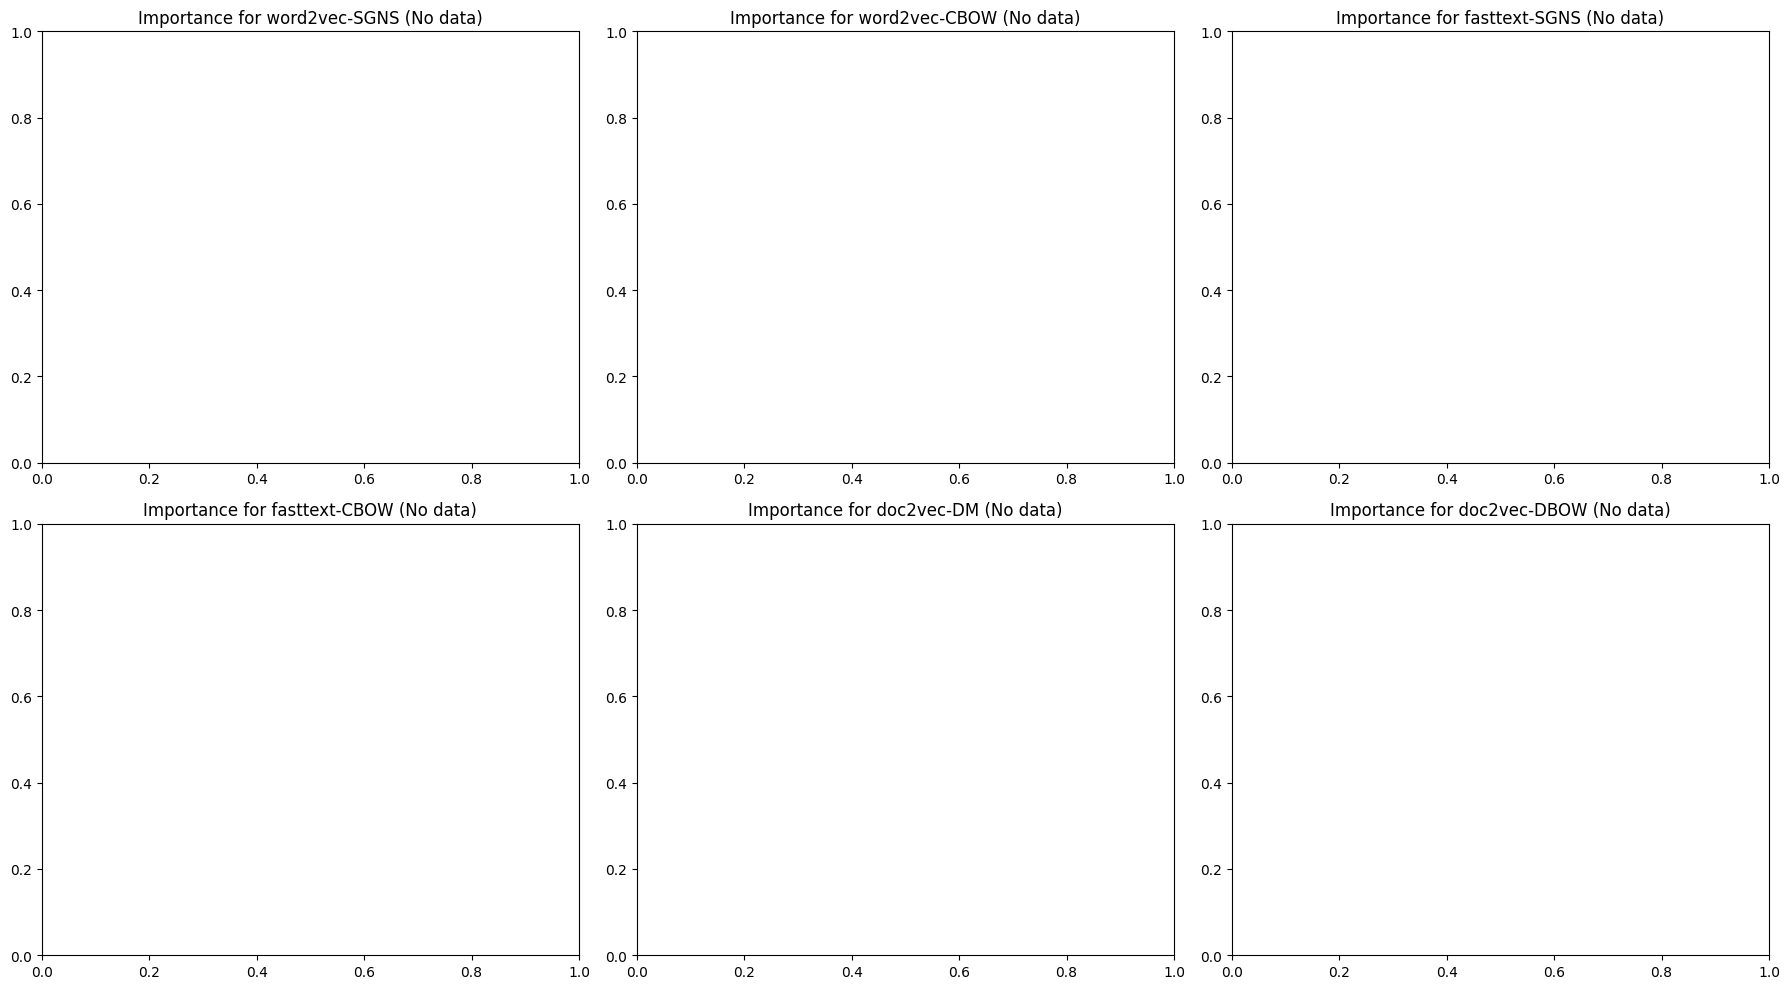

In [ ]:
import numpy as np
import pandas as pd
import random
import warnings
import optuna
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')

class RecommenderSystem:
   
    def __init__(self, random_seed=1234):
        self.random_seed = random_seed
        np.random.seed(random_seed)
        random.seed(random_seed)
        self.embedding_type, self.embedding_model, self.aggregation_type = None, None, None
        self.feature_scaler, self.regressor, self.chosen_regressor = None, None, None
        self.tested_regressors = {}

    def _preprocess_text(self, text):
        if pd.isna(text): return []
        return word_tokenize(text.lower())

    def _learn_word_embedding_model(self, train_texts, **hyperparams):
        
        default_params = {'vector_size': 100, 'window': 5, 'min_count': 5, 'workers': 4, 'epochs': 10, 'seed': self.random_seed}
        params = {**default_params, **hyperparams}
        ModelClass = Word2Vec if self.embedding_type == 'word2vec' else FastText
        self.embedding_model = ModelClass(sentences=train_texts, **params)

    def _learn_doc_embedding_model(self, train_texts, **hyperparams):
        tagged_docs = [TaggedDocument(words=tokens, tags=[i]) for i, tokens in enumerate(train_texts)]
        default_params = {'vector_size': 100, 'window': 8, 'min_count': 5, 'workers': 4, 'epochs': 20, 'seed': self.random_seed}
        params = {**default_params, **hyperparams}
        self.embedding_model = Doc2Vec(documents=tagged_docs, **params)

    def _create_aggregated_embeddings(self, processed_texts):
        embeddings = []
        for tokens in processed_texts:
            token_vectors = [self.embedding_model.wv[token] for token in tokens if token in self.embedding_model.wv]
            if not token_vectors:
                doc_embedding = np.zeros(self.embedding_model.wv.vector_size)
            elif self.aggregation_type == 'mean':
                doc_embedding = np.mean(token_vectors, axis=0)
            elif self.aggregation_type == 'sum':
                doc_embedding = np.sum(token_vectors, axis=0)
            elif self.aggregation_type == 'max':
                doc_embedding = np.max(token_vectors, axis=0)
            else:
                raise ValueError(f"Unsupported aggregation type: '{self.aggregation_type}'")
            embeddings.append(doc_embedding)
        return np.array(embeddings)

    def _create_document_vectors(self, processed_texts):
        if self.embedding_type == 'doc2vec':
            return np.array([self.embedding_model.infer_vector(tokens) for tokens in processed_texts])
        else:
            return self._create_aggregated_embeddings(processed_texts)

    def _apply_feature_manipulation(self, train_vectors, manipulation_type):
        self.feature_manipulation_type = manipulation_type
        if manipulation_type == 'standard':
            self.feature_scaler = StandardScaler()
        elif manipulation_type == 'minmax':
            self.feature_scaler = MinMaxScaler()
        elif manipulation_type == 'none':
            self.feature_scaler = None
            return train_vectors
        else:
            raise ValueError(f"Unsupported feature manipulation type: '{manipulation_type}'")
        return self.feature_scaler.fit_transform(train_vectors)

    def _experiment_and_select_regressor(self, X_train, y_train, X_val, y_val):
        print("\nExperimenting with 4 regression algorithms...")
        regressors_to_test = {
            'Ridge': Ridge(random_state=self.random_seed),
            'Lasso': Lasso(random_state=self.random_seed),
            'RandomForest': RandomForestRegressor(random_state=self.random_seed, n_jobs=-1),
            'GradientBoosting': GradientBoostingRegressor(random_state=self.random_seed),
        }
        for name, model in regressors_to_test.items():
            model.fit(X_train, y_train)
            r2 = r2_score(y_val, model.predict(X_val))
            self.tested_regressors[name] = {'model': model, 'r2': r2}
            print(f"  - {name}: Validation R² = {r2:.4f}")
        self.chosen_regressor = max(self.tested_regressors, key=lambda k: self.tested_regressors[k]['r2'])
        self.regressor = self.tested_regressors[self.chosen_regressor]['model']

    def fit(self, train_texts, train_ratings, val_texts, val_ratings, 
            embedding_type, mode, aggregation_type=None, feature_manipulation='standard'):
        self.embedding_type, self.aggregation_type = embedding_type, aggregation_type
        processed_train_texts = [self._preprocess_text(text) for text in train_texts]
        
        embedding_hyperparams = {}
        if self.embedding_type == 'doc2vec':
            embedding_hyperparams['dm'] = 1 if mode == 'DM' else 0
            embedding_hyperparams['dbow_words'] = 1 if mode == 'DBOW' else 0
            self._learn_doc_embedding_model(processed_train_texts, **embedding_hyperparams)
            self.aggregation_type = 'doc2vec'
        else:
            embedding_hyperparams['sg'] = 1 if mode == 'SGNS' else 0
            self._learn_word_embedding_model(processed_train_texts, **embedding_hyperparams)
        
        processed_val_texts = [self._preprocess_text(text) for text in val_texts]
        X_train = self._create_document_vectors(processed_train_texts)
        X_val = self._create_document_vectors(processed_val_texts)
        X_train_processed = self._apply_feature_manipulation(X_train, feature_manipulation)
        X_val_processed = self.feature_scaler.transform(X_val) if self.feature_scaler else X_val
        self._experiment_and_select_regressor(X_train_processed, train_ratings, X_val_processed, val_ratings)
        return self


class HyperparameterOptimizer:
    
    def __init__(self, train_data, val_data, selected_regressor_name, random_seed=1234):
        self.train_data, self.val_data, self.random_seed = train_data, val_data, random_seed
        self.selected_regressor_name = selected_regressor_name
        self.processed_train_texts = [word_tokenize(str(t).lower()) for t in self.train_data['text']]
        self.tagged_train_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(self.processed_train_texts)]
        self.n_trials, self.direction = 16, 'maximize'
        self.sampler = TPESampler(seed=random_seed)
        self.studies = {}

    def _report_hyperparameter_ranges(self):
        print("\n" + "-"*60)
        print("Hyperparameter Ranges for Optimization:")
        print(f"  - vector_size:          [50, 200]")
        print(f"  - window:               [5, 15]")
        print(f"  - min_count:            [2, 10]")
        print(f"  - epochs:               [10, 40]")
        print(f"  - aggregation_type:     ['mean', 'sum', 'max']")
        print(f"  - feature_manipulation: ['standard', 'minmax', 'none']")
        print(f"  - Regressor '{self.selected_regressor_name}' params will be tuned.")
        print("-"*60)

    def _objective(self, trial, emb_type, mode):
        emb_hp = {'vector_size': trial.suggest_int('vector_size', 50, 200, step=50), 'window': trial.suggest_int('window', 5, 15), 'min_count': trial.suggest_int('min_count', 2, 10), 'epochs': trial.suggest_int('epochs', 10, 40, step=5), 'seed': self.random_seed, 'workers': 1}
        if emb_type != 'doc2vec':
            agg_type = trial.suggest_categorical('aggregation_type', ['mean', 'sum', 'max'])
            emb_hp['sg'] = 1 if mode == 'SGNS' else 0
        else:
            agg_type, emb_hp['dm'] = 'doc2vec', 1 if mode == 'DM' else 0
            emb_hp['dbow_words'] = 1 if mode == 'DBOW' else 0
        
        feature_manip = trial.suggest_categorical('feature_manipulation', ['standard', 'minmax', 'none'])
        
        regressor = None
        if self.selected_regressor_name == 'RandomForest':
        
            hp = {'n_estimators': trial.suggest_int('rf_n_estimators', 100, 500, step=100), 'max_depth': trial.suggest_int('rf_max_depth', 10, 30), 'random_state': self.random_seed, 'n_jobs': 1}
            regressor = RandomForestRegressor(**hp)
        elif self.selected_regressor_name == 'GradientBoosting':
            hp = {'n_estimators': trial.suggest_int('gb_n_estimators', 100, 500, step=100), 'learning_rate': trial.suggest_float('gb_lr', 0.01, 0.2, log=True), 'max_depth': trial.suggest_int('gb_max_depth', 3, 8), 'random_state': self.random_seed}
            regressor = GradientBoostingRegressor(**hp)
        else: # Handle Ridge and Lasso
             alpha = trial.suggest_float(f'{self.selected_regressor_name.lower()}_alpha', 1e-2, 1e2, log=True)
             ModelClass = Ridge if self.selected_regressor_name == 'Ridge' else Lasso
             regressor = ModelClass(alpha=alpha, random_state=self.random_seed)

        ModelClass = {'doc2vec': Doc2Vec, 'word2vec': Word2Vec, 'fasttext': FastText}[emb_type]
        docs = self.tagged_train_corpus if emb_type == 'doc2vec' else self.processed_train_texts
        embedding_model = ModelClass(documents=docs, **emb_hp) if emb_type == 'doc2vec' else ModelClass(sentences=docs, **emb_hp)
        
        rs_temp = RecommenderSystem(); rs_temp.embedding_model = embedding_model; rs_temp.aggregation_type = agg_type; rs_temp.embedding_type = emb_type
        processed_val_texts = [rs_temp._preprocess_text(text) for text in self.val_data['text']]
        
        X_train = rs_temp._create_document_vectors(self.processed_train_texts)
        X_val = rs_temp._create_document_vectors(processed_val_texts)
            
        if feature_manip != 'none':
            scaler = StandardScaler() if feature_manip == 'standard' else MinMaxScaler()
            X_train, X_val = scaler.fit_transform(X_train), scaler.transform(X_val)
        
        regressor.fit(X_train, self.train_data['stars'].values)
        return r2_score(self.val_data['stars'].values, regressor.predict(X_val))

    def run_all_optimizations(self):
        self._report_hyperparameter_ranges()
        settings = [{'name': f'{e}-{m}', 'emb': e, 'mode': m} for e, m in [('word2vec','SGNS'), ('word2vec','CBOW'), ('fasttext','SGNS'), ('fasttext','CBOW'), ('doc2vec','DM'), ('doc2vec','DBOW')]]
        
        for s in settings:
            print(f"\n--- Optimizing: {s['name'].upper()} on 3 CPU cores ---")
            
         
            study_name = f"{s['name']}_{self.selected_regressor_name}"
            storage_path = f"sqlite:///{study_name}.db"
            
            study = optuna.create_study(
                study_name=study_name,
                storage=storage_path,
                direction=self.direction,
                sampler=self.sampler,
                load_if_exists=True
            )
            
            study.optimize(
                lambda trial: self._objective(trial, s['emb'], s['mode']), 
                n_trials=self.n_trials, 
                n_jobs=4,
                show_progress_bar=True
            )
            self.studies[s['name']] = study
    
    def generate_final_report(self):
        print("\n" + "="*80)
        print("FINAL HYPERPARAMETER OPTIMIZATION REPORT")
        rows = [{'Setting': name, 'Best_R2': study.best_value, **study.best_params} for name, study in self.studies.items()]
        print(pd.DataFrame(rows).to_string())
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        for i, (name, study) in enumerate(self.studies.items()):
            try:
                optuna.visualization.plot_param_importances(study, ax=axes[i])
                axes[i].set_title(f"Importance for {name}")
            except: axes[i].set_title(f"Importance for {name} (No data)")
        plt.tight_layout()
        plt.show()

def demonstrate_section_3_1_experiment(train_data, val_data):
    print("#"*80)
    print("###   PART 3.1: EXPERIMENTING TO SELECT BEST REGRESSOR TYPE   ###")
    configurations = [
        {'embedding_type': 'word2vec', 'mode': 'SGNS', 'aggregation_type': 'mean', 'feature_manipulation': 'standard'},
        {'embedding_type': 'word2vec', 'mode': 'CBOW', 'aggregation_type': 'mean', 'feature_manipulation': 'standard'},
        {'embedding_type': 'fasttext', 'mode': 'SGNS', 'aggregation_type': 'mean', 'feature_manipulation': 'standard'},
        {'embedding_type': 'fasttext', 'mode': 'CBOW', 'aggregation_type': 'mean', 'feature_manipulation': 'standard'},
        {'embedding_type': 'doc2vec',  'mode': 'DM', 'aggregation_type': 'doc2vec','feature_manipulation': 'standard'},
        {'embedding_type': 'doc2vec',  'mode': 'DBOW', 'aggregation_type': 'doc2vec','feature_manipulation': 'standard'}
    ]
    best_overall_system, best_overall_score = None, -1.0
    for config in configurations:
        system = RecommenderSystem(random_seed=1234)
        system.fit(train_data['text'].values, train_data['stars'].values, val_data['text'].values, val_data['stars'].values, **config)
        current_score = system.tested_regressors[system.chosen_regressor]['r2']
        if current_score > best_overall_score:
            best_overall_score, best_overall_system = current_score, system
    
    print("\n" + "="*80)
    print("###   RESULT OF 3.1: SINGLE BEST SYSTEM CHOSEN   ###")
    print(f"The regressor to optimize in Section 3.2 is: '{best_overall_system.chosen_regressor}'")
    print("="*80)
    return best_overall_system.chosen_regressor

if __name__ == '__main__':
    try:
        train_data = pd.read_csv("train_reviews.csv")
        val_data   = pd.read_csv("val_reviews.csv")
        
        chosen_regressor_name = demonstrate_section_3_1_experiment(train_data, val_data)
        
        optimizer = HyperparameterOptimizer(train_data, val_data, selected_regressor_name=chosen_regressor_name)
        optimizer.run_all_optimizations()
        optimizer.generate_final_report()

    except FileNotFoundError:
        print("\nERROR: CSV files not found. Please run Section 1 first.")

4 Evaluation

In [ ]:
import torch
import torchmetrics
import torchmetrics.functional as tmf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from nltk.tokenize import word_tokenize
import warnings
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec, FastText
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from torchmetrics.functional.retrieval import retrieval_normalized_dcg
warnings.filterwarnings('ignore')

#Part1:Reconstructing optimized models from the results of section 3

print("\n" + "#"*80)
print("###   PATCH: RE-TRAINING FINAL 6 MODELS USING BEST PARAMS FROM SECTION 3   ###")
print("#"*80)

# This code assumes that the 'optimizer' object and data dataframes from the execution of previous sections are present in memory
final_trained_systems = {}

# Initial preprocessing of training texts, which is the same for all models
processed_train_texts = [word_tokenize(str(t).lower()) for t in train_data['text']]
tagged_train_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_train_texts)]
chosen_regressor_name = optimizer.selected_regressor_name

for name, study in optimizer.studies.items():
    print(f"\n--- Re-training final model for: '{name}' ---")
    best_params = study.best_params
    emb_type, mode = name.split('-')

    # 1.Train the Embedding model with the best parameters
    emb_hp = {
        'vector_size': best_params.get('vector_size'), 'window': best_params.get('window'),
        'min_count': best_params.get('min_count'), 'epochs': best_params.get('epochs'),
        'seed': 1234, 'workers': 4
    }
    if emb_type == 'doc2vec':
        emb_hp['dm'] = 1 if mode == 'DM' else 0
        embedding_model = Doc2Vec(documents=tagged_train_corpus, **emb_hp)
    else:
        emb_hp['sg'] = 1 if mode == 'SGNS' else 0
        ModelClass = Word2Vec if emb_type == 'word2vec' else FastText
        embedding_model = ModelClass(sentences=processed_train_texts, **emb_hp)

    # 2.Create document vectors
    rs_temp = RecommenderSystem()
    rs_temp.embedding_model = embedding_model
    rs_temp.aggregation_type = best_params.get('aggregation_type', 'doc2vec')
    rs_temp.embedding_type = emb_type
    X_train = rs_temp._create_document_vectors(processed_train_texts)

    #3.Train the Scaler
    scaler = None
    feature_manip = best_params.get('feature_manipulation')
    if feature_manip == 'standard':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    elif feature_manip == 'minmax':
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)

    #4.Train the Regressor
    if chosen_regressor_name == 'RandomForest':
        hp = {k.replace('rf_', ''): v for k, v in best_params.items() if k.startswith('rf_')}
        regressor = RandomForestRegressor(random_state=1234, n_jobs=-1, **hp)
    elif chosen_regressor_name == 'GradientBoosting':
        hp = {k.replace('gb_', ''): v for k, v in best_params.items() if k.startswith('gb_')}
        regressor = GradientBoostingRegressor(random_state=1234, **hp)
    else:
        alpha_key = f'{chosen_regressor_name.lower()}_alpha'
        alpha = best_params.get(alpha_key)
        ModelClass = Ridge if chosen_regressor_name == 'Ridge' else Lasso
        regressor = ModelClass(alpha=alpha, random_state=1234)
    regressor.fit(X_train, train_data['stars'].values)

    #5.Store all trained components
    final_trained_systems[name] = {
        'embedding_model': embedding_model, 'scaler': scaler, 'regressor': regressor
    }
    print(f"--- Model for '{name}' successfully re-trained and stored. ---")

#Part 2:Comprehensive evaluation class 

class ComprehensiveEvaluator:
    """
    A complete and methodologically correct evaluator for the 6 optimized systems.
    """
    def __init__(self, optimized_systems, best_params_per_system, train_data, val_data, test_data, users_df, restaurants_df):
        self.optimized_systems = optimized_systems
        self.best_params = best_params_per_system
        self.train_data, self.val_data, self.test_data = train_data, val_data, test_data
        self.users_df, self.restaurants_df = users_df, restaurants_df
        self.evaluation_results = {}
        self.system_names = list(self.optimized_systems.keys())

    def _preprocess_text(self, text):
        if pd.isna(text): return []
        return word_tokenize(str(text).lower())

    def _predict_with_components(self, system_name, texts):
        system_components = self.optimized_systems.get(system_name)
        if not system_components:
            print(f"Warning: Components for system '{system_name}' not found. Skipping prediction.")
            return np.zeros(len(texts))

        embedding_model, scaler, regressor = system_components.get('embedding_model'), system_components.get('scaler'), system_components.get('regressor')
        if embedding_model is None or regressor is None:
            raise ValueError(f"Incomplete components for system '{system_name}'")

        embedding_type = 'doc2vec' if isinstance(embedding_model, Doc2Vec) else 'word_based'
        aggregation_type = self.best_params[system_name].get('aggregation_type', 'doc2vec')
        processed_texts = [self._preprocess_text(text) for text in texts]

        if embedding_type == 'doc2vec':
            embeddings = np.array([embedding_model.infer_vector(tokens) for tokens in processed_texts])
        else:
            vecs = []
            for tokens in processed_texts:
                word_vecs = [embedding_model.wv[t] for t in tokens if t in embedding_model.wv]
                if not word_vecs: vecs.append(np.zeros(embedding_model.vector_size))
                elif aggregation_type == 'mean': vecs.append(np.mean(word_vecs, axis=0))
                elif aggregation_type == 'sum': vecs.append(np.sum(word_vecs, axis=0))
                elif aggregation_type == 'max': vecs.append(np.max(word_vecs, axis=0))
            embeddings = np.array(vecs)
        
        if scaler:
            embeddings = scaler.transform(embeddings)
        return regressor.predict(embeddings)

    def calculate_regression_metrics(self, y_true, y_pred):
        preds_t, target_t = torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_true, dtype=torch.float32)
        return {
            'MAE': torchmetrics.MeanAbsoluteError()(preds_t, target_t).item(),
            'RMSE': torch.sqrt(torchmetrics.MeanSquaredError()(preds_t, target_t)).item(),
            'MAPE': torchmetrics.MeanAbsolutePercentageError()(preds_t, target_t).item(),
            'R2': torchmetrics.R2Score()(preds_t, target_t).item(),
            'CCC': torchmetrics.ConcordanceCorrCoef()(preds_t, target_t).item(),
            'Pearson_r': torchmetrics.PearsonCorrCoef()(preds_t, target_t).item(),
        }

    def calculate_ranking_metrics(self, df_with_preds):
        user_groups = df_with_preds.groupby('user_id')
        all_user_metrics = []
        for _, group in user_groups:
            if len(group) < 2: continue
            y_true, y_pred = group['stars'].values, group['predicted_stars'].values
            spearman, _ = spearmanr(y_true, y_pred)
            kendall, _ = kendalltau(y_true, y_pred)
            preds_t, target_t = torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_true, dtype=torch.float32)
            ndcg_scores = {f'NDCG@{k}': retrieval_normalized_dcg(preds_t, target_t, top_k=k).item() for k in [1, 3, 5, 10]}
            all_user_metrics.append({'Spearman_rho': 0 if np.isnan(spearman) else spearman, 'Kendall_tau': 0 if np.isnan(kendall) else kendall, **ndcg_scores})
        if not all_user_metrics: return {k: 0.0 for k in ['Spearman_rho', 'Kendall_tau', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10']}
        return pd.DataFrame(all_user_metrics).mean().to_dict()

    def evaluate_all_systems(self):
        print("\n--- Starting Comprehensive Evaluation of All 6 Optimized Systems ---")
        datasets = {'Train': self.train_data, 'Validation': self.val_data, 'Test': self.test_data}
        for system_name in self.system_names:
            self.evaluation_results[system_name] = {}
            for set_name, dataset in datasets.items():
                print(f"Evaluating '{system_name}' on '{set_name}' data...")
                predictions = self._predict_with_components(system_name, dataset['text'].values)
                reg_metrics = self.calculate_regression_metrics(dataset['stars'].values, predictions)
                dataset_with_preds = dataset.copy(); dataset_with_preds['predicted_stars'] = predictions
                rank_metrics = self.calculate_ranking_metrics(dataset_with_preds)
                self.evaluation_results[system_name][set_name] = {**reg_metrics, **rank_metrics}

    def recommend_restaurants_for_tashalee(self):
        print("\n" + "="*80)
        print("TOP-10 RESTAURANT RECOMMENDATIONS FOR USER TASHALEE")
        try:
            best_system_name = max(self.evaluation_results, key=lambda s: self.evaluation_results[s]['Test']['R2'])
            print(f"Using best performing system based on Test R2: '{best_system_name}'")
            restaurants_to_rate = self.val_data.drop_duplicates(subset=['business_id']).merge(self.restaurants_df[['business_id', 'name']], on='business_id')
            predictions = self._predict_with_components(best_system_name, restaurants_to_rate['text'].values)
            restaurants_to_rate['predicted_rating'] = predictions
            print("\nTop-10 Recommended Restaurants:")
            print(restaurants_to_rate.nlargest(10, 'predicted_rating')[['name', 'predicted_rating']].to_string(index=False))
        except Exception as e:
            print(f"Could not generate recommendations for Tashalee. Error: {e}")

    def generate_full_report(self):
        self.evaluate_all_systems()
        print("\n--- Evaluation Summary ---")
        # Example: Displaying a summary of results for the test set
        test_results = {name: results['Test'] for name, results in self.evaluation_results.items() if 'Test' in results}
        if test_results:
            print(pd.DataFrame.from_dict(test_results, orient='index').sort_values(by='R2', ascending=False))
        self.recommend_restaurants_for_tashalee()

#   Part 3: Final execution block
# Initialize the evaluator using the reconstructed models
evaluator = ComprehensiveEvaluator(
    optimized_systems=final_trained_systems,
    best_params_per_system={name: study.best_params for name, study in optimizer.studies.items()},
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    users_df=users_df,
    restaurants_df=restaurants_df
)
# Execute the complete evaluation and reporting
evaluator.generate_full_report()


################################################################################
###   PATCH: RE-TRAINING FINAL 6 MODELS USING BEST PARAMS FROM SECTION 3   ###
################################################################################

--- Re-training final model for: 'word2vec-SGNS' ---
--- Model for 'word2vec-SGNS' successfully re-trained and stored. ---

--- Re-training final model for: 'word2vec-CBOW' ---
--- Model for 'word2vec-CBOW' successfully re-trained and stored. ---

--- Re-training final model for: 'fasttext-SGNS' ---
--- Model for 'fasttext-SGNS' successfully re-trained and stored. ---

--- Re-training final model for: 'fasttext-CBOW' ---
--- Model for 'fasttext-CBOW' successfully re-trained and stored. ---

--- Re-training final model for: 'doc2vec-DM' ---
--- Model for 'doc2vec-DM' successfully re-trained and stored. ---

--- Re-training final model for: 'doc2vec-DBOW' ---
--- Model for 'doc2vec-DBOW' successfully re-trained and stored. ---

--- Starting Comprehe

In [ ]:
import pickle

# File path to save the results
results_filepath = 'optimizer_results.pkl'

# Data to save
data_to_save = {
    'optimizer': optimizer,
    'train_data': train_data,
    'val_data': val_data,
    'test_data': test_data,
    'users_df': users_df,
    'restaurants_df': restaurants_df
}

try:
    with open(results_filepath, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"SUCCESS: All results have been safely saved to the file '{results_filepath}'")
    print("It is now SAFE to restart the kernel.")
except Exception as e:
    print(f"ERROR: Could not save the results. DO NOT RESTART THE KERNEL. Error: {e}")

SUCCESS: All results have been safely saved to the file 'optimizer_results.pkl'
It is now SAFE to restart the kernel.
